# Tropical Pacific High Res BGC run
- look at variability ENSO, TIW in the run, SST, maybe also EUC if that relates to OMZ
- should I connect some SST analysis with some BGCM tracer? 
    - do I have oxygen? I think that would be worthwhile and then reference Yassir's paper

### Import modules, set up cluster

In [4]:
from high_low_res_pop import read_dat, pop_add_cyclic, continuous_meet, adjust_pop_grid, normal_lons, pop_find_lat_ind, pop_find_lon_ind

In [2]:
from distributed import Client
from ncar_jobqueue import NCARCluster
from dask_jobqueue import PBSCluster

In [3]:
# Setup your PBSCluster
cluster = PBSCluster(
    cores=2, # The number of cores you want
    memory='50 GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus=2:mem=50GB', # Specify resources
    project='NCGD0011', # Input your project ID here
    walltime='04:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)
# Scale up
cluster.scale(24)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/deppenme/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/deppenme/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.7:44269,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/deppenme/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Get data

#### SST

In [10]:
path_highres = '/glade/campaign/cgd/oce/projects/FOSI_BGC/HR/g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001/ocn/proc/tseries/day_1/'
path_lowres = '/glade/campaign/cesm/development/bgcwg/projects/CESM2-OMIP2-like-4p2z-run/g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch/ocn/proc/tseries/day_1/'

In [9]:
%%time
# get the high res data 
flist_high = glob.glob(path_highres + "g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001.pop.h.nday1.SST.*.nc") 
ds_sst_high = read_dat(flist_high, ['SST'], pop=True) 
ds_sst_high_cyc = pop_add_cyclic(ds_sst_high)

# get grid
ds_grid = pt.get_grid('POP_tx0.1v3')
dso_grid = pop_add_cyclic(ds_grid)

CPU times: user 5.08 s, sys: 1.41 s, total: 6.49 s
Wall time: 17.7 s


In [12]:
%%time
# get low res data 
ds_sst_lowres = xr.open_dataset(path_lowres + 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch.pop.h.nday1.SST.19580101-20211231.nc')
ds_sst_low_cyc = pop_add_cyclic(ds_sst_lowres)

CPU times: user 63.4 ms, sys: 5.84 ms, total: 69.3 ms
Wall time: 196 ms


In [15]:
%%time
# get oisst
ds_oisst = xr.open_mfdataset('/glade/collections/rda/data/ds277.8/MW/????/??????????????-REMSS-L4_GHRSST-SSTfnd-MW_OI-GLOB-v02.0-fv05.0.nc',
                                parallel='True')

CPU times: user 41.5 s, sys: 1.26 s, total: 42.7 s
Wall time: 44.7 s


#### NPP

In [21]:
variables = ['x_graze_mesozoo_zint', 'photoC_diaz_zint', 'photoC_diat_zint', 'photoC_sp_zint', 'photoC_cocco_zint']
coords = {'x':'TLONG','y':'TLAT'}
keepthese=['z_t','z_t_150m','time_bound','time','dz','TAREA','REGION_MASK'] + variables + list(coords.values())

def preprocess(ds):
    ds=ds.mean(dim='time')
    return ds

In [22]:
%%time
# daily high res
case = 'g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001'

ds_fosi_x01_daily = xr.Dataset()

for var in ['photoC_cocco_zint', 'photoC_diat_zint', 'photoC_diaz_zint', 'photoC_sp_zint']:
    
    print('starting on ', var)
    ################ FOSI
    
    #ds_tmp = xr.open_dataset(path+case+'.pop.h.'+var+'.??????-??????.nc')
    #ds_tmp['time'] = time
    
    files = sorted(glob.glob(f'{path_highres}/{case}.pop.h.nday1.{var}_2.*.nc'))       
    ds_tmp = xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",combine='nested',
                       drop_variables=["transport_components", "transport_regions"], decode_times=True, chunks={'time':-1, 'nlon':100, 'nlat':100})

    keep_vars=['z_t','z_t_150m','time_bound','dz','TLAT','TLONG','time'] + [var + '_2']

    ds_tmp = ds_tmp.drop([v for v in ds_tmp.variables if v not in keep_vars])
        
    ds_fosi_x01_daily = xr.merge([ds_fosi_x01_daily,ds_tmp])
    

starting on  photoC_cocco_zint
starting on  photoC_diat_zint
starting on  photoC_diaz_zint
starting on  photoC_sp_zint
CPU times: user 1min 13s, sys: 3.33 s, total: 1min 16s
Wall time: 1min 27s


In [23]:
# get total npp which is the sum over the photo terms
ds_fosi_x01_daily["time"] = ds_fosi_x01_daily.time_bound.compute().mean(dim="d2")
ds_fosi_x01_daily['photoC_TOT_zint'] = (ds_fosi_x01_daily['photoC_cocco_zint_2'] + ds_fosi_x01_daily['photoC_diat_zint_2'] 
                                  + ds_fosi_x01_daily['photoC_diaz_zint_2'] + ds_fosi_x01_daily['photoC_sp_zint_2'])

In [31]:
case_lr = 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch'

var = variables[2]
files = sorted(glob.glob(f'{path_lowres}/{case_lr}.pop.h.ecosys.nday1.{var}_2.*.nc'))

In [39]:
# Low res NPP
ds_fosi_x1_daily = xr.Dataset()
case_lr = 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch'
for var in variables[1:]:
    
    print('starting on ', var)
    ################ FOSI
    
    files = sorted(glob.glob(f'{path_lowres}/{case_lr}.pop.h.ecosys.nday1.{var}_2.*.nc'))       
    ds_tmp = xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",combine='nested',
                       drop_variables=["transport_components", "transport_regions"], decode_times=True, chunks={'time':-1, 'nlon':100, 'nlat':100})

    keep_vars=['z_t','z_t_150m','time_bound','dz','TLAT','TLONG','time'] + [var + '_2']

    ds_tmp = ds_tmp.drop([v for v in ds_tmp.variables if v not in keep_vars])
        
    ds_fosi_x1_daily = xr.merge([ds_fosi_x1_daily,ds_tmp])

starting on  photoC_diaz_zint
starting on  photoC_diat_zint
starting on  photoC_sp_zint
starting on  photoC_cocco_zint


In [40]:
ds_fosi_x1_daily["time"] = ds_fosi_x1_daily.time_bound.compute().mean(dim="d2")

In [42]:
ds_fosi_x1_daily['photoC_TOT_zint'] = (ds_fosi_x1_daily['photoC_cocco_zint_2'] + ds_fosi_x1_daily['photoC_diat_zint_2'] 
                                       +
                                       ds_fosi_x1_daily['photoC_diaz_zint_2'] + ds_fosi_x1_daily['photoC_sp_zint_2'])

#### Get the grid information

In [5]:
ds_grid_01 = pop_tools.get_grid('POP_tx0.1v3')
lons_01 = ds_grid_01.TLONG
lats_01 = ds_grid_01.TLAT
area_01 = ds_grid_01.TAREA
area_m_01 = ds_grid_01.TAREA * 1e-4
lons_norm_01 = normal_lons(lons_01)

ds_grid_x1 = pop_tools.get_grid('POP_gx1v7')
lons_x1 = ds_grid_x1.TLONG
lats_x1 = ds_grid_x1.TLAT
area_x1 = ds_grid_x1.TAREA
area_m_x1 = ds_grid_x1.TAREA * 1e-4
lons_norm_x1 = normal_lons(lons_x1)

In [14]:
%%time
ds_grid_lowres = pt.get_grid('POP_gx1v7')
dso_grid_lowres = pop_add_cyclic(ds_grid_lowres)
# this works so I really don't get why the one above does not work 

CPU times: user 61.5 ms, sys: 6.02 ms, total: 67.5 ms
Wall time: 87.6 ms


### Get where TLAT & TLONG

In [16]:
lon_140_lr = 231
lat_0n_lr = 187
lon_140_hr = 3299
lat_0n_hr = 1182

n34_hr = [1131, 1231, 3000, 3500]
n34_lr = [168, 205, 204, 248]

In [17]:
%%time
sst_0N140W_highres = ds_sst_high.isel(nlat=lat_0n_hr, nlon=lon_140_hr).SST.load()
sst_0N140W_lowres = ds_sst_lowres.isel(nlat=lat_0n_lr, nlon=lon_140_lr).SST.load()
oisst_0N140W = ds_oisst.analysed_sst.sel(lat=0, lon=-140, method='nearest').load()

CPU times: user 1min 6s, sys: 2.57 s, total: 1min 9s
Wall time: 1min 27s


In [18]:
# make the Nino3.4 index 170 - 120, 5-5 
sst_n34_lr = ds_sst_lowres.SST.isel(nlat=slice(n34_lr[0], n34_lr[1]), nlon=slice(n34_lr[2], n34_lr[3]))
sst_n34_hr = ds_sst_high.SST.isel(nlat=slice(n34_hr[0], n34_hr[1]), nlon=slice(n34_hr[2], n34_hr[3]))
oisst_n34 = ds_oisst.analysed_sst.sel(lat=slice(-5,5), lon=slice(-170,-120))

sst_n34_lr_anom = sst_n34_lr.groupby('time.month') - sst_n34_lr.groupby('time.month').mean('time')
sst_n34_hr_anom = sst_n34_hr.groupby('time.month') - sst_n34_hr.groupby('time.month').mean('time')
oisst_n34_anom = oisst_n34.groupby('time.month') - oisst_n34.groupby('time.month').mean('time')

## Plot TIW SST and NPP for high res vs low res and a map

### Get Pacific specifically so that you can easily plot

In [19]:
%%time
sst_Pac_highres =  ds_sst_high.SST.where((ds_sst_high.TLONG > 180) & (ds_sst_high.TLONG.values < 250) & (ds_sst_high.TLAT < 10) & (ds_sst_high.TLAT > -10),
                                         drop=True).load()

CPU times: user 2min 10s, sys: 23.6 s, total: 2min 34s
Wall time: 4min 25s


In [43]:
%%time
npp_tot_Pac_highres = ds_fosi_x01_daily.photoC_TOT_zint.where((ds_fosi_x01_daily.TLONG > 180) & (ds_fosi_x01_daily.TLONG.values < 250) & (ds_fosi_x01_daily.TLAT < 10) & (ds_fosi_x01_daily.TLAT > -10),
                                         drop=True).load()

In [44]:
%%time
sst_Pac_lowres =  ds_sst_lowres.SST.where((ds_sst_lowres.TLONG > 180) & (ds_sst_lowres.TLONG.values < 250) & (ds_sst_lowres.TLAT < 10) & (ds_sst_lowres.TLAT > -10),
                                         drop=True).load()


CPU times: user 3.69 s, sys: 2.35 s, total: 6.04 s
Wall time: 6.89 s


In [45]:
%%time
npp_tot_Pac_lowres =  ds_fosi_x1_daily.photoC_TOT_zint.where((ds_fosi_x1_daily.TLONG > 180) & (ds_fosi_x1_daily.TLONG.values < 250) & (ds_fosi_x1_daily.TLAT < 10) & (ds_fosi_x1_daily.TLAT > -10),
                                         drop=True).load()


CPU times: user 6.7 s, sys: 694 ms, total: 7.39 s
Wall time: 34.8 s


In [46]:
grid_pac_hr = ds_grid_01.where((ds_grid_01.TLONG > 180) & (ds_grid_01.TLONG.values < 250) & (ds_grid_01.TLAT < 10) & (ds_grid_01.TLAT > -10),
                     drop=True).load()

In [47]:
grid_pac_lr = ds_grid_x1.where((ds_grid_x1.TLONG > 180) & (ds_grid_x1.TLONG.values < 250) & (ds_grid_x1.TLAT < 10) & (ds_grid_x1.TLAT > -10),
                     drop=True).load()

### Plot

In [48]:
NPP_conv_factor= 0.01 * 86400 # to arrive at units of mmol/m2/d

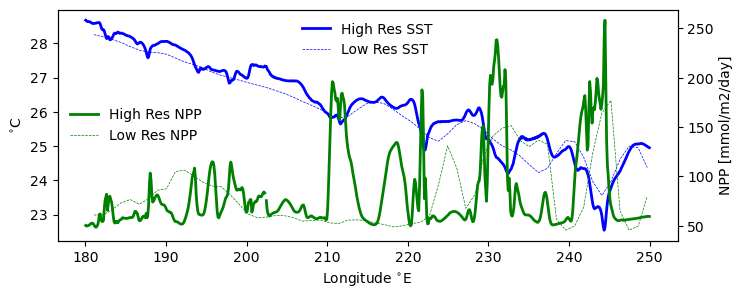

In [87]:
fig, ax = plt.subplots(1, 1, figsize=(8,3))
line_sst_hr = ax.plot(grid_pac_hr.TLONG.isel(nlat=5), 
                      sst_Pac_highres.isel(time=999).where((sst_Pac_highres.TLAT>1.9) & (sst_Pac_highres.TLAT<2.0), drop=True)[0,:],
       label='High Res SST', c='blue', lw=2)

line_sst_lr = ax.plot(grid_pac_lr.TLONG.isel(nlat=5), 
                      sst_Pac_lowres.isel(time=999).where((sst_Pac_lowres.TLAT>1.7) & (sst_Pac_lowres.TLAT<2.0), drop=True)[0,:],
       label='Low Res SST', c='blue', lw=0.5, ls='--')

axnpp = ax.twinx()
line_npp_hr = axnpp.plot(grid_pac_hr.TLONG.isel(nlat=5), 
           (npp_tot_Pac_highres.isel(time=999).where((sst_Pac_highres.TLAT>1.9) & (sst_Pac_highres.TLAT<2.0), drop=True)[0,:]*NPP_conv_factor),
          c='green', lw=2, label='High Res NPP')
line_npp_lr = axnpp.plot(grid_pac_lr.TLONG.isel(nlat=5), 
           (npp_tot_Pac_lowres.isel(time=999).where((npp_tot_Pac_lowres.TLAT>1.7) & (npp_tot_Pac_lowres.TLAT<2.0), drop=True)[0,:]*NPP_conv_factor),
          c='green', lw=0.5, ls='--', label='Low Res NPP')

ax.legend(frameon=False, loc='upper center')
axnpp.legend(frameon=False, loc='center left')
axnpp.set_ylabel('NPP [mmol/m2/day]')

ax.set_ylabel(r'$^{\circ}$C')
ax.set_xlabel(r'Longitude $^{\circ}$E')


plt.savefig('NPP_SST_day_along2N_HR_LR.png', bbox_inches='tight', dpi=300)

In [104]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import mpl_toolkits.axes_grid1.inset_locator

In [120]:
str(sst_Pac_highres.isel(time=999).time.values)[:10]

'1960-09-28'

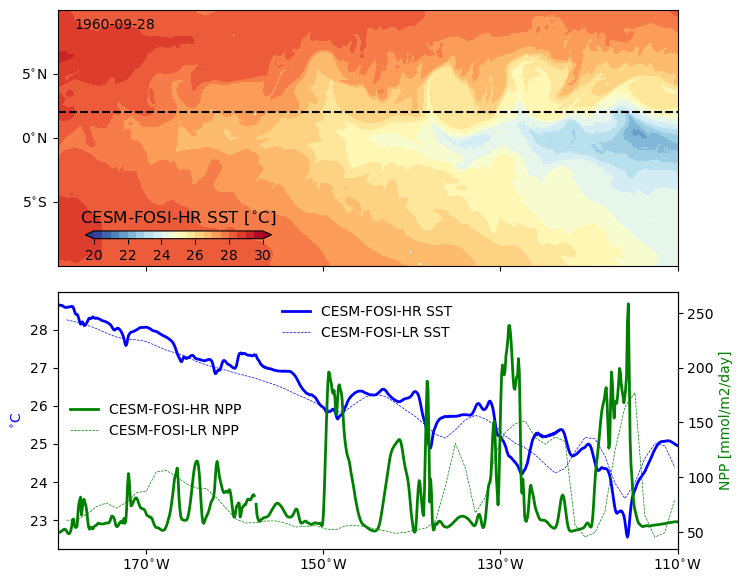

In [131]:
fig, ax = plt.subplots(2, 1, figsize=(8,7), sharex=True)

dat = ax[0].contourf(grid_pac_hr.TLONG, grid_pac_hr.TLAT, sst_Pac_highres.isel(time=999),
               levels=np.arange(20,30.5,0.5), cmap='RdYlBu_r', extend='both')
ax[0].text(182, 8.5, str(sst_Pac_highres.isel(time=999).time.values)[:10])
# plt.colorbar(dat, orientation="horizontal", pad=0.1, location='top', ax=ax[0], shrink=0.5)
cbaxes = mpl_toolkits.axes_grid1.inset_locator.inset_axes(ax[0], width="30%", height="3%", loc='lower left', borderpad=2) 
cbar = plt.colorbar(dat, cax=cbaxes, orientation='horizontal', ticks=range(20,32,2))
cbaxes.set_title(r'CESM-FOSI-HR SST [$^{\circ}$C]')

ax[0].axhline(2, ls='--', c='k')

line_sst_hr = ax[1].plot(grid_pac_hr.TLONG.isel(nlat=5), 
                      sst_Pac_highres.isel(time=999).where((sst_Pac_highres.TLAT>1.9) & (sst_Pac_highres.TLAT<2.0), drop=True)[0,:],
       label='CESM-FOSI-HR SST', c='blue', lw=2)

line_sst_lr = ax[1].plot(grid_pac_lr.TLONG.isel(nlat=5), 
                      sst_Pac_lowres.isel(time=999).where((sst_Pac_lowres.TLAT>1.7) & (sst_Pac_lowres.TLAT<2.0), drop=True)[0,:],
       label='CESM-FOSI-LR SST', c='blue', lw=0.5, ls='--')

axnpp = ax[1].twinx()
line_npp_hr = axnpp.plot(grid_pac_hr.TLONG.isel(nlat=5), 
           (npp_tot_Pac_highres.isel(time=999).where((sst_Pac_highres.TLAT>1.9) & (sst_Pac_highres.TLAT<2.0), drop=True)[0,:]*NPP_conv_factor),
          c='green', lw=2, label='CESM-FOSI-HR NPP')
line_npp_lr = axnpp.plot(grid_pac_lr.TLONG.isel(nlat=5), 
           (npp_tot_Pac_lowres.isel(time=999).where((npp_tot_Pac_lowres.TLAT>1.7) & (npp_tot_Pac_lowres.TLAT<2.0), drop=True)[0,:]*NPP_conv_factor),
          c='green', lw=0.5, ls='--', label='CESM-FOSI-LR NPP')

ax[1].legend(frameon=False, loc='upper center')
axnpp.legend(frameon=False, loc='center left')
axnpp.set_ylabel('NPP [mmol/m2/day]', c='green')

ax[1].set_ylabel(r'$^{\circ}$C', c='blue')
# ax[1].set_xlabel(r'Longitude $^{\circ}$E')

ax[0].set_yticks(np.arange(-5,10,5))
ax[0].set_yticklabels([r'5$^{\circ}$S', r'0$^{\circ}$N', r'5$^{\circ}$N'])

ax[1].set_xticks([190, 210, 230, 250])
ax[1].set_xticklabels([r'170$^{\circ}$W', r'150$^{\circ}$W', r'130$^{\circ}$W', r'110$^{\circ}$W'])

plt.subplots_adjust(hspace=0.1)

plt.savefig('MAP_SST_NPP_SST_day_along2N_HR_LR.png', bbox_inches='tight', dpi=300)

#### Correlation

In [61]:
sst_2n_140w_hr = sst_Pac_highres.where(
    (sst_Pac_highres.TLAT>1.9) & (sst_Pac_highres.TLAT<2.0) & (sst_Pac_highres.TLONG>220) & (sst_Pac_highres.TLONG<220.1),
    drop=True).load()

In [62]:
npp_2n_140w_hr =  npp_tot_Pac_highres.where(
    (npp_tot_Pac_highres.TLAT>1.9) & (npp_tot_Pac_highres.TLAT<2.0) & (npp_tot_Pac_highres.TLONG>220) & (npp_tot_Pac_highres.TLONG<220.1),
    drop=True).load()

In [64]:
sst_2n_140w_lr = sst_Pac_lowres.where((sst_Pac_lowres.TLAT>1.7) & (sst_Pac_lowres.TLAT<2.0) & (sst_Pac_lowres.TLONG>220) & (sst_Pac_lowres.TLONG<221), drop=True).load()

In [65]:
npp_2n_140w_lr = npp_tot_Pac_lowres.where((npp_tot_Pac_lowres.TLAT>1.7) & (npp_tot_Pac_lowres.TLAT<2.0) & (npp_tot_Pac_lowres.TLONG>220) & (npp_tot_Pac_lowres.TLONG<221), drop=True).load()

In [79]:
from scipy.stats import pearsonr

In [80]:
pearsonr(npp_2n_140w_hr[:,0,0].fillna(0),sst_2n_140w_hr[:,0,0].fillna(0))#.values

(-0.372064115204167, 0.0)

In [86]:
pearsonr(npp_2n_140w_lr[:,0,0].fillna(0),sst_2n_140w_lr[:,0,0].fillna(0))#.values

(-0.44149939979321284, 0.0)

Text(0.5, 1.0, 'LR')

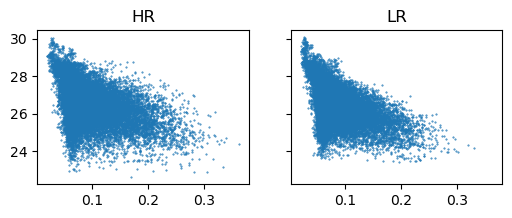

In [85]:
fig, ax = plt.subplots(1, 2, figsize=(6, 2), sharex=True, sharey=True)
ax[0].scatter(npp_2n_140w_hr[:,0,0].fillna(0),sst_2n_140w_hr[:,0,0].fillna(0), s=0.2)#.values
ax[0].set_title('HR')

ax[1].scatter(npp_2n_140w_lr[:,0,0].fillna(0),sst_2n_140w_lr[:,0,0].fillna(0), s=0.2)#.values
ax[1].set_title('LR')


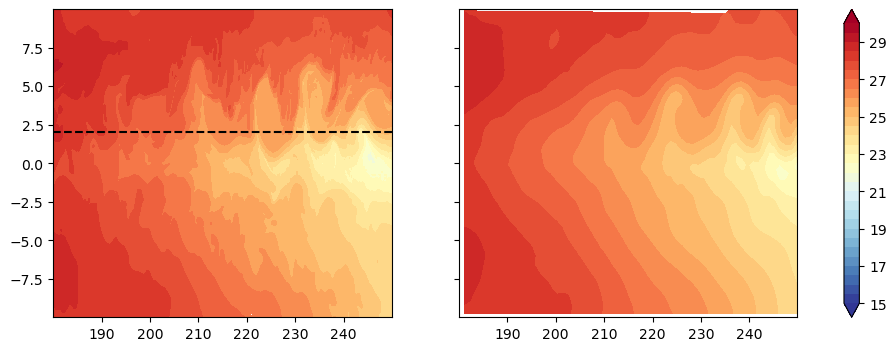

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)

dat = ax[0].contourf(grid_pac.TLONG, grid_pac.TLAT, sst_Pac_highres.isel(time=999), 
            levels=np.arange(15,30.5,0.5), cmap='RdYlBu_r', extend='both')
plt.colorbar(dat, ax=ax[:])

dat = ax[1].contourf(grid_pac_lr.TLONG, grid_pac_lr.TLAT, sst_Pac_lowres.isel(time=999),  
            levels=np.arange(15,30.5,0.5), cmap='RdYlBu_r', extend='both')

ax[0].axhline(2, ls='--', c='k')

### Interannual variability

In [134]:
npp_hr_nino34 = npp_tot_Pac_highres.where((npp_tot_Pac_highres.TLAT < 5) & (npp_tot_Pac_highres.TLAT > -5) 
                          &
                          (npp_tot_Pac_highres.TLONG > 190) & (npp_tot_Pac_highres.TLONG < 240)).mean(dim=['nlat', 'nlon']).load()

In [136]:
npp_lr_nino34 = npp_tot_Pac_lowres.where((npp_tot_Pac_lowres.TLAT < 5) & (npp_tot_Pac_lowres.TLAT > -5) 
                          &
                          (npp_tot_Pac_lowres.TLONG > 190) & (npp_tot_Pac_lowres.TLONG < 240)).mean(dim=['nlat', 'nlon']).load()

In [158]:
print('high res sst var:', npp_hr_nino34.var().values)
print('high res sst var:', npp_lr_nino34.var().values)

high res sst var: 0.00035982776898890734


high res sst var: 0.00033803205587901175


In [137]:
sst_hr_nino34 = sst_Pac_highres.where((sst_Pac_highres.TLAT < 5) & (sst_Pac_highres.TLAT > -5) 
                          &
                          (sst_Pac_highres.TLONG > 190) & (sst_Pac_highres.TLONG < 240)).mean(dim=['nlat', 'nlon']).load()

In [138]:
sst_lr_nino34 = sst_Pac_lowres.where((sst_Pac_lowres.TLAT < 5) & (sst_Pac_lowres.TLAT > -5) 
                          &
                          (sst_Pac_lowres.TLONG > 190) & (sst_Pac_lowres.TLONG < 240)).mean(dim=['nlat', 'nlon']).load()

In [22]:
# %%time
# # oist_ninpp_tot_Pac_lowrest_n34_anom.mean(dim=['lon','lat']).load()
# lr_nino_ind = sst_n34_lr_anom.mean(dim=['nlon','nlat']).load()
# hr_nino_ind = sst_n34_hr_anom.mean(dim=['nlon','nlat']).load()

CPU times: user 2min 15s, sys: 5.98 s, total: 2min 21s
Wall time: 5min 37s


### Add NPP to interannual varibility
- look at NPP high res vs low res 

In [140]:
sst_lr_nino34_anom = sst_lr_nino34.groupby('time.month') - sst_lr_nino34.groupby('time.month').mean('time')
sst_hr_nino34_anom = sst_hr_nino34.groupby('time.month') - sst_hr_nino34.groupby('time.month').mean('time')

In [142]:
npp_lr_nino34_anom = npp_lr_nino34.groupby('time.month') - npp_lr_nino34.groupby('time.month').mean('time')
npp_hr_nino34_anom = npp_hr_nino34.groupby('time.month') - npp_hr_nino34.groupby('time.month').mean('time')

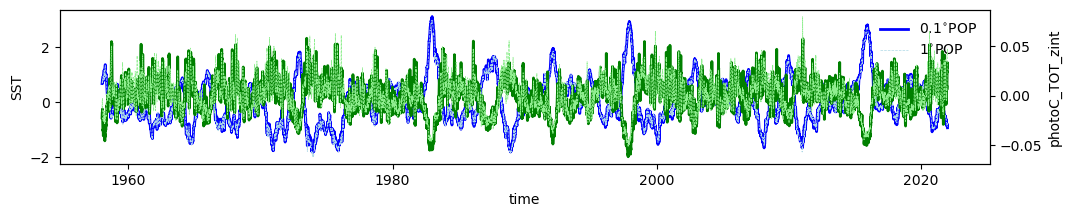

In [145]:
fig, ax = plt.subplots(1, 1, figsize=(12,2))
# oist_nino_ind.plot(ax=ax, label='OISST')
sst_hr_nino34_anom.plot(ax=ax, label=r'0.1$^{\circ}$POP', c='blue', lw=2)
sst_lr_nino34_anom.plot(ax=ax, label=r'1$^{\circ}$POP' ,ls='--', lw=0.5, c='lightblue')
plt.legend(frameon=False)

# ax_npp = ax.twinx()
# npp_hr_nino34_anom.plot(ax=ax_npp, label=r'0.1$^{\circ}$POP', c='green', lw=2)
# npp_lr_nino34_anom.plot(ax=ax_npp, label=r'1$^{\circ}$POP' ,ls='--', lw=0.5, c='lightgreen')

# npp_lr_nino34_anom

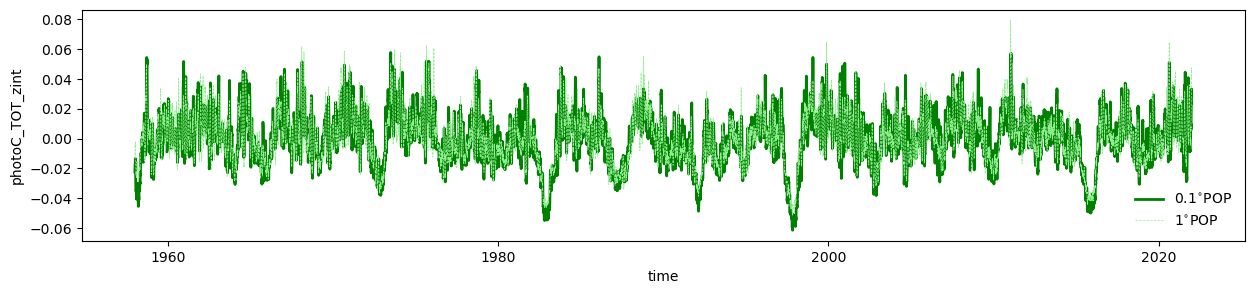

In [148]:
fig, ax_npp = plt.subplots(1, 1, figsize=(15,3))
npp_hr_nino34_anom.plot(ax=ax_npp, label=r'0.1$^{\circ}$POP', c='green', lw=2)
npp_lr_nino34_anom.plot(ax=ax_npp, label=r'1$^{\circ}$POP' ,ls='--', lw=0.5, c='lightgreen')
ax_npp.legend(frameon=False)

In [155]:
print('high res variance: ', (npp_hr_nino34_anom*NPP_conv_factor).var().values)
print('low res variance: ', (npp_lr_nino34_anom*NPP_conv_factor).var().values)

high res variance:  224.31703186035156
low res variance:  210.3970489501953


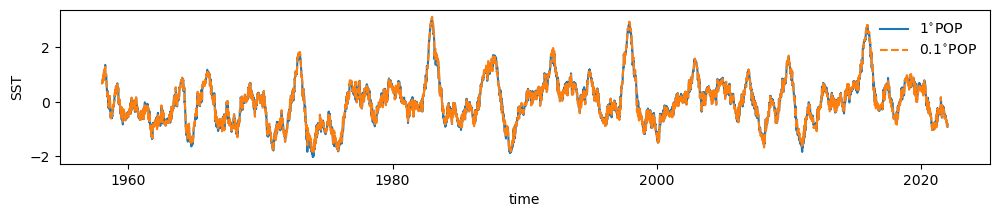

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(12,2))
# oist_nino_ind.plot(ax=ax, label='OISST')
lr_nino_ind.plot(ax=ax, label=r'1$^{\circ}$POP')
hr_nino_ind.plot(ax=ax, label=r'0.1$^{\circ}$POP' ,ls='--')
plt.legend(frameon=False)

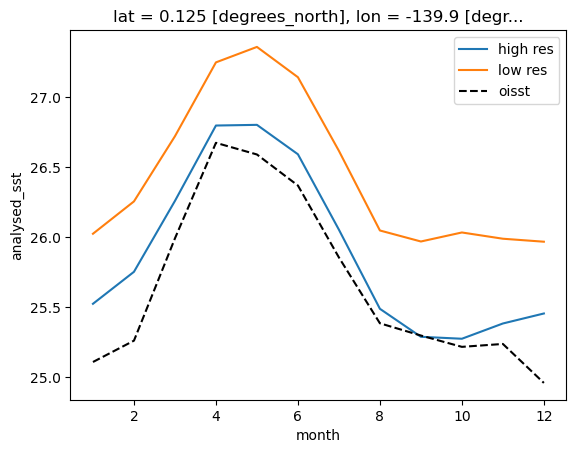

In [34]:
sst_0N140W_highres.groupby('time.month').mean('time').plot(label='high res')
sst_0N140W_lowres.groupby('time.month').mean('time').plot(label='low res')
(oisst_0N140W.groupby('time.month').mean('time')-273.15).plot(c='k', ls='--', label='oisst')
plt.legend()

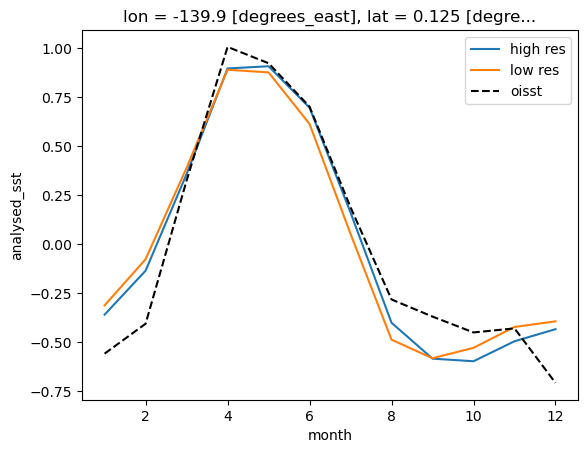

In [20]:
(sst_0N140W_highres.groupby('time.month').mean('time')-sst_0N140W_highres.mean('time')).plot(label='high res')
(sst_0N140W_lowres.groupby('time.month').mean('time')-sst_0N140W_lowres.mean('time')).plot(label='low res')
((oisst_0N140W.groupby('time.month').mean('time')-273.15)-(oisst_0N140W.mean('time')-273.15)).plot(c='k', ls='--', label='oisst')
plt.legend()

### TIW KE

In [106]:
%%time
# get the high res data 
flist_high_v = glob.glob(path_highres + "g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001.pop.h.nday1.V1_1.*nc") 
ds_v_high_alternative = xr.open_mfdataset(flist_high_v, parallel=True)
# ds_v_high = read_dat(flist_high_v, ['V1_1'], pop=True) 
# ds_v_high_cyc = pop_add_cyclic(ds_v_high)


CPU times: user 8.83 s, sys: 5.51 s, total: 14.3 s
Wall time: 38.1 s


In [114]:
%%time
# HIGH RES TKE 

ds_tiwke_0N140W = xr.open_zarr('TIWKE0N140W_highres_pop.zarr/')

CPU times: user 15.9 ms, sys: 725 µs, total: 16.7 ms
Wall time: 20.7 ms


In [111]:
ds_v_high.V1_1.TLAT.isel(nlat=(lat_0n_hr-20), nlon=lon_140_hr)

<xarray.DataArray 'TLAT' ()>
array(-1.949652)
Coordinates:
    ULONG    float64 ...
    ULAT     float64 ...
    TLONG    float64 220.0
    TLAT     float64 -1.95
Attributes:
    long_name:  array of t-grid latitudes
    units:      degrees_north

In [113]:
%%time
# HIGH RES TKE 

# ds_tiwke_0N140W = xr.open_zarr('TIWKE0N140W_highres_pop.zarr/')
v_2N140W =ds_v_high.V1_1.isel(nlat=lat_0n_hr-20, nlon=lon_140_hr).load()

v_2N140W_bp = xfilter.bandpass(v_2N140W.chunk({'time':-1}), 'time', (1/12, 1/33), 
                                cycles_per="D",
                                num_discard=0).compute()

v2_2N140W = (v_2N140W_bp**2).chunk({'time':-1}).load()

vTIW_KE_2N140W = xfilter.lowpass(v2_2N140W, 'time', (1/20),
                                 cycles_per="D",
                                 num_discard=0).compute()

CPU times: user 667 ms, sys: 19.3 ms, total: 686 ms
Wall time: 4.76 s


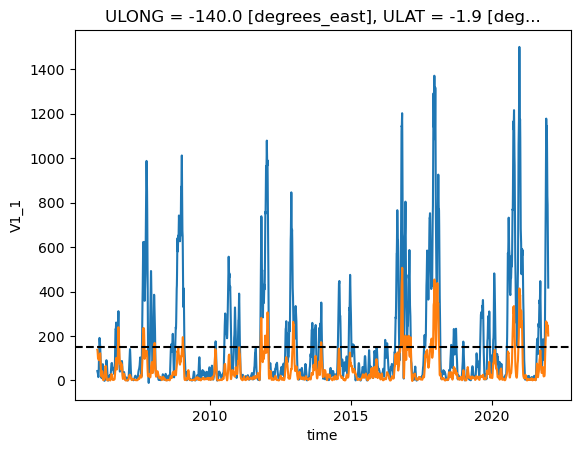

In [117]:
ds_tiwke_0N140W.TIWKE0N140W.plot()

vTIW_KE_2N140W.plot()
plt.gca().axhline(150, ls='--', c='k')

In [124]:
npp_tot_Pac_highres.where((npp_tot_Pac_highres.TLAT < 2) & (npp_tot_Pac_highres.TLAT > 1.9) & (npp_tot_Pac_highres.TLONG < 220.1) & (npp_tot_Pac_highres.TLONG > 220), 
                          drop=True)[0,0,:]

<xarray.DataArray 'photoC_TOT_zint' (nlon: 1)>
array([0.08243135], dtype=float32)
Coordinates:
    TLONG    (nlon) float64 220.1
    TLAT     (nlon) float64 1.95
    time     object 1958-01-01 12:15:50.000002
Dimensions without coordinates: nlon

#### Get test data to test plotting

#### get high res data

In [28]:
# # monthly 
# case = 'g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001'
# path = '/glade/campaign/cgd/oce/projects/FOSI_BGC/HR/' + case + '/ocn/proc/tseries/month_1'

# # %%time
# ds_fosi_x01 = xr.Dataset()

# for var in variables:
    
#     print('starting on ', var)
#     ################ FOSI
    
#     #ds_tmp = xr.open_dataset(path+case+'.pop.h.'+var+'.??????-??????.nc')
#     #ds_tmp['time'] = time
    
#     files = sorted(glob.glob(f'{path}/{case}.pop.h.{var}.??????-??????.nc'))       
#     ds_tmp = xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",combine='nested',
#                        drop_variables=["transport_components", "transport_regions"], decode_times=True)

#     keep_vars=['z_t','z_t_150m','time_bound','dz','TLAT','TLONG','time'] + [var]

#     ds_tmp = ds_tmp.drop([v for v in ds_tmp.variables if v not in keep_vars])
        
#     ds_fosi_x01 = xr.merge([ds_fosi_x01,ds_tmp])

starting on  x_graze_mesozoo_zint
starting on  photoC_diaz_zint
starting on  photoC_diat_zint
starting on  photoC_sp_zint
starting on  photoC_cocco_zint


In [16]:
%%time
# daily 
case = 'g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001'

ds_fosi_x01_daily = xr.Dataset()

for var in ['photoC_cocco_zint', 'photoC_diat_zint', 'photoC_diaz_zint', 'photoC_sp_zint']:
    
    print('starting on ', var)
    ################ FOSI
    
    #ds_tmp = xr.open_dataset(path+case+'.pop.h.'+var+'.??????-??????.nc')
    #ds_tmp['time'] = time
    
    files = sorted(glob.glob(f'{path_highres}/{case}.pop.h.nday1.{var}_2.*.nc'))       
    ds_tmp = xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",combine='nested',
                       drop_variables=["transport_components", "transport_regions"], decode_times=True, chunks={'time':-1, 'nlon':100, 'nlat':100})

    keep_vars=['z_t','z_t_150m','time_bound','dz','TLAT','TLONG','time'] + [var + '_2']

    ds_tmp = ds_tmp.drop([v for v in ds_tmp.variables if v not in keep_vars])
        
    ds_fosi_x01_daily = xr.merge([ds_fosi_x01_daily,ds_tmp])

starting on  photoC_cocco_zint
starting on  photoC_diat_zint
starting on  photoC_diaz_zint
starting on  photoC_sp_zint
CPU times: user 1min, sys: 2.37 s, total: 1min 3s
Wall time: 1min 13s


In [17]:
ds_fosi_x01_daily["time"] = ds_fosi_x01_daily.time_bound.compute().mean(dim="d2")
ds_fosi_x01_daily['photoC_TOT_zint'] = (ds_fosi_x01_daily['photoC_cocco_zint_2'] + ds_fosi_x01_daily['photoC_diat_zint_2'] 
                                  + ds_fosi_x01_daily['photoC_diaz_zint_2'] + ds_fosi_x01_daily['photoC_sp_zint_2'])

In [37]:
ds_fosi_x01_daily.photoC_TOT_zint

<xarray.DataArray 'photoC_TOT_zint' (time: 23360, nlat: 2400, nlon: 3600)>
dask.array<add, shape=(23360, 2400, 3600), dtype=float32, chunksize=(365, 100, 100), chunktype=numpy.ndarray>
Coordinates:
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(100, 100), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(100, 100), meta=np.ndarray>
  * time     (time) object 1958-01-01 12:15:50.000002 ... 2021-12-31 12:00:00
Dimensions without coordinates: nlat, nlon

In [22]:
%%time
photo_hr_0n140w = ds_fosi_x01_daily.isel(nlat=lat_0n_hr, nlon=lon_140_hr).load()
print('done')

done
CPU times: user 21.3 s, sys: 849 ms, total: 22.1 s
Wall time: 3min 50s


In [73]:
%%time
photo_hr_nino34 = ds_fosi_x01_daily.isel(nlat=slice(n34_hr[0], n34_hr[1]), nlon=slice(n34_hr[2], n34_hr[3])).mean(dim=['nlat', 'nlon']).load()
print('done')

done
CPU times: user 1min 59s, sys: 4.36 s, total: 2min 3s
Wall time: 25min 42s


In [77]:
photo_hr_nino34.to_zarr('photo_info_highres_Nino34.zarr')

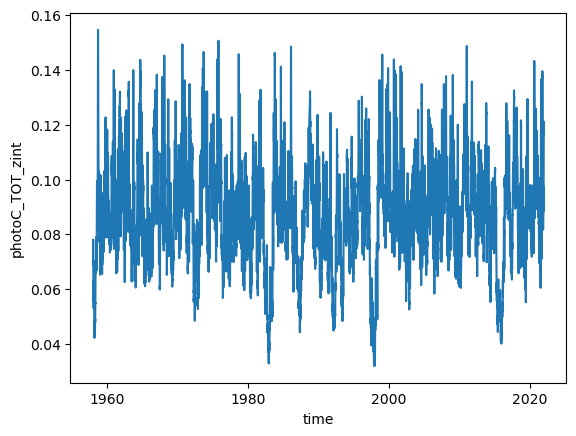

In [76]:
photo_hr_nino34.photoC_TOT_zint.plot()

### investigate the problems with the time axis

In [37]:
photo_hr_0n140w.nbytes/1e9

0.001028412

In [38]:
photo_hr_0n140w.to_zarr('photo_info_highres_0N140W.zarr')

In [55]:
list_indices = range(len(ds_tiwke_0N140W.TIWKE0N140W))
# ds_tiwke_0N140W.TIWKE0N140W.where(ds_tiwke_0N140W.TIWKE0N140W>150).squeeze()
da = xr.DataArray(
    data=temperature,
    dims=["x", "y", "time"],
    coords=dict(
        lon=(["x", "y"], lon),
        lat=(["x", "y"], lat),
        time=time,
        reference_time=reference_time,
    ),
    attrs=dict(
        description="Ambient temperature.",
        units="degC",
    ),
)

In [56]:
list_indices.where(ds_tiwke_0N140W.TIWKE0N140W>150, drop=True)


AttributeError: 'range' object has no attribute 'where'

In [59]:
cluster.scale(24)

In [62]:
photo_hr_0n140w.photoC_TOT_zint.sel(time=slice('2006','2021'))

<xarray.DataArray 'photoC_TOT_zint' (time: 5840)>
array([0.2278234 , 0.22966188, 0.20058775, ..., 0.2536043 , 0.25904238,
       0.26837382], dtype=float32)
Coordinates:
    TLONG    float64 220.0
    TLAT     float64 0.05
  * time     (time) object 2006-01-01 12:00:00 ... 2021-12-31 12:00:00

In [61]:
ds_tiwke_0N140W.TIWKE0N140W.sel(time=slice('2006','2021'))

<xarray.DataArray 'TIWKE0N140W' (time: 5839)>
dask.array<getitem, shape=(5839,), dtype=float64, chunksize=(5839,), chunktype=numpy.ndarray>
Coordinates:
    TLAT     float64 ...
    TLONG    float64 ...
    ULAT     float64 ...
    ULONG    float64 ...
  * time     (time) object 2006-01-02 00:00:00 ... 2021-12-31 00:00:00

In [69]:
a = ds_tiwke_0N140W.TIWKE0N140W.sel(time=slice('2006','2021')).fillna(0).values
b = photo_hr_0n140w.photoC_TOT_zint.sel(time=slice('2006','2021')).isel(time=slice(0,-1)).fillna(0).values

In [71]:
from scipy.stats import pearsonr

In [72]:
pearsonr(a, b)

PearsonRResult(statistic=0.041815296579676475, pvalue=0.0013936616035963658)

In [68]:
xr.corr(ds_tiwke_0N140W.TIWKE0N140W.sel(time=slice('2006','2021')).fillna(0), 
            photo_hr_0n140w.photoC_TOT_zint.sel(time=slice('2006','2021')).isel(time=slice(0,-1)).fillna(0),
       dim='time').values

array(nan)

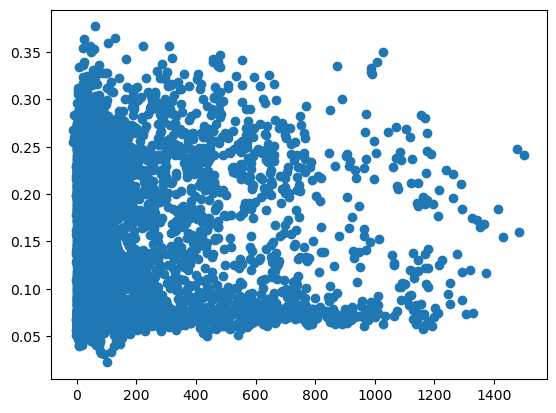

In [64]:
plt.scatter(ds_tiwke_0N140W.TIWKE0N140W.sel(time=slice('2006','2021')), 
            photo_hr_0n140w.photoC_TOT_zint.sel(time=slice('2006','2021')).isel(time=slice(0,-1)))

#### get low res data

In [67]:
# case_lr = 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.001branch'
case_lr = 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch'
path_lr = '/glade/campaign/cesm/development/bgcwg/projects/CESM2-OMIP2-like-4p2z-run/'+case+'/ocn/proc/tseries/month_1/'

/glade/scratch/kristenk/archive/
#path = '/glade/scratch/kristenk/archive/' + case + '/ocn/proc/tseries/month_1/'

In [104]:
variables

['x_graze_mesozoo_zint',
 'photoC_diaz_zint',
 'photoC_diat_zint',
 'photoC_sp_zint',
 'photoC_cocco_zint']

In [125]:
# this is hard coded because the nice way did not work and I could not figure out why 
ds_fosi_x1 = xr.Dataset()

for var in variables:
    
    print('starting on ', var)
    ################ FOSI
    
    ds_tmp = xr.open_dataset(('/glade/campaign/cesm/development/bgcwg/projects/CESM2-OMIP2-like-4p2z-run/g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.001branch/ocn/proc/tseries/month_1/'
                              +
                              'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.001branch.pop.h.' + var +'.195801-202112.nc'))
    # ds_tmp['time'] = time
    
    # files = sorted(glob.glob(f'{path_lr}/{case_lr}.pop.h.{var}.??????-??????.nc'))     
    # print(files)
    # ds_tmp = xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",combine='nested',
    #                    drop_variables=["transport_components", "transport_regions"], decode_times=True)

    keep_vars=['z_t','z_t_150m','time_bound','dz','TLAT','TLONG','time'] + [var]

    ds_tmp = ds_tmp.drop([v for v in ds_tmp.variables if v not in keep_vars])
        
    ds_fosi_x1 = xr.merge([ds_fosi_x1,ds_tmp])

starting on  x_graze_mesozoo_zint
starting on  photoC_diaz_zint
starting on  photoC_diat_zint
starting on  photoC_sp_zint
starting on  photoC_cocco_zint


In [126]:
ds_fosi_x1["time"] = ds_fosi_x1.time_bound.compute().mean(dim="d2")

In [127]:
ds_fosi_x1['photoC_TOT_zint'] = ds_fosi_x1['photoC_cocco_zint'] + ds_fosi_x1['photoC_diat_zint'] + ds_fosi_x1['photoC_diaz_zint'] + ds_fosi_x1['photoC_sp_zint']

In [ ]:
ds_fosi_x1.photoC_TOT_zint.isel(nlat=lat_0n_lr, nlon=lon_140_lr).groupby('time.month').mean('time').plot()
ds_fosi_x01.photoC_TOT_zint.isel(nlat=lat_0n_hr, nlon=lon_140_hr).groupby('time.month').mean('time').plot(label='high res')
plt.legend()

In [ ]:
ds_out = ds_fosi_x1.photoC_TOT_zint.isel(nlat=lat_0n_lr, nlon=lon_140_lr).groupby('time.month').mean('time').to_dataset(name='lr_tot_0n140w')
ds_out['hr_tot_0n140w'] = ds_fosi_x01.photoC_TOT_zint.isel(nlat=lat_0n_hr, nlon=lon_140_hr).groupby('time.month').mean('time')
ds_out.to_zarr('tot_npp_0N140W_high_low.zarr')

In [ ]:
oisst_tstdat = (ds_oisst.analysed_sst.isel(time=100)-273.15).load()
pop_tstdat = ds_sst_high_cyc.SST.sel(time='1998-04-11').isel(time=0).load()
pop_lt_tstdat = ds_sst_low_cyc.SST.sel(time='1998-04-11').isel(time=0).load()

CPU times: user 1.66 s, sys: 77.4 ms, total: 1.73 s
Wall time: 1.96 s


Text(0.5, 0, 'Longitude $^{\\circ}$E')

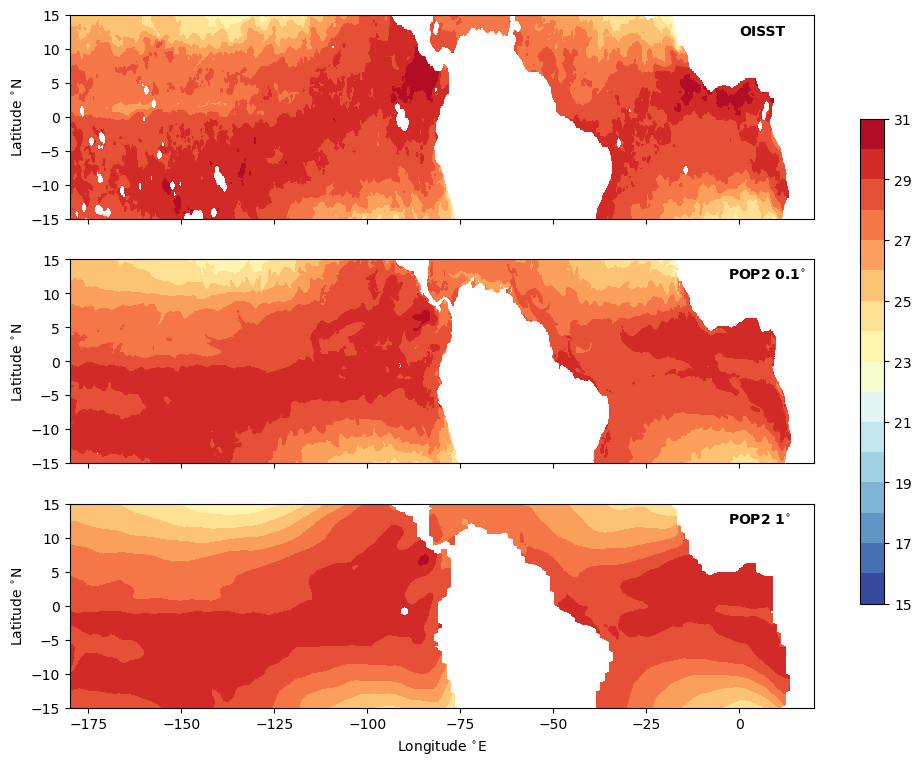

In [16]:
%%time
# get them to plot together ; you might have to move the longitude =/
fig, ax = plt.subplots(3, 1, figsize=(12,9), sharex=True, sharey=True)
ax[0].contourf(ds_oisst.lon, ds_oisst.lat, oisst_tstdat, levels=np.arange(15,32,1), cmap='RdYlBu_r')
# (ds_oisst_tst.analysed_sst.isel(time=100)-273.15).plot(levels=np.arange(15,32,1), cmap='RdYlBu_r', ax=ax[0])
ax[0].set_ylim(-15,15)

dat = ax[1].contourf(dso_grid.TLONG, dso_grid.TLAT, pop_tstdat, levels=np.arange(15,32,1), cmap='RdYlBu_r')
ax[1].set_ylim(-15,15)
ax[1].set_xlim(-180,20)

dat = ax[2].contourf(dso_grid_lowres.TLONG, dso_grid_lowres.TLAT, pop_lt_tstdat, levels=np.arange(15,32,1), cmap='RdYlBu_r')
ax[2].set_ylim(-15,15)
ax[2].set_xlim(-180,20)


plt.colorbar(dat, ax=ax[:], shrink=0.7)

ax[0].text(0,12, 'OISST', c='k', weight='bold')
ax[1].text(-3,12, r'POP2 0.1$^{\circ}$', c='k', weight='bold')
ax[2].text(-3,12, r'POP2 1$^{\circ}$', c='k', weight='bold')

ax[0].set_ylabel(r'Latitude $^{\circ}$N')
ax[1].set_ylabel(r'Latitude $^{\circ}$N')
ax[2].set_ylabel(r'Latitude $^{\circ}$N')
ax[2].set_xlabel(r'Longitude $^{\circ}$E')

## Get mean and variance to plot 

In [17]:
# this means I don't need the .mean and .var down below anymore
ds_oisst_timvar = xr.open_zarr('oisst_pac_derived.zarr')
ds_pophr_timvar = xr.open_zarr('pop_pac_derived.zarr')
ds_poplr_timvar = xr.open_zarr('pop_lr_pac_derived.zarr')

In [23]:
ds_sst_high_cyc.SST.sel(nlat=slice(1000,1400), nlon=slice(1100,2300)).nbytes/1e9

44.8512

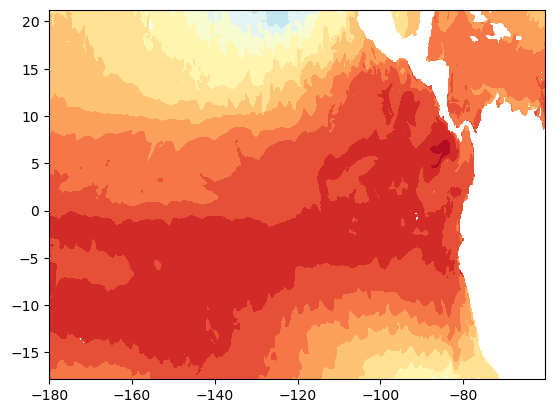

In [22]:
dat = plt.contourf(dso_grid.TLONG.sel(nlat=slice(1000,1400), nlon=slice(1100,2300)), dso_grid.TLAT.sel(nlat=slice(1000,1400), nlon=slice(1100,2300)), 
                   pop_tstdat.sel(nlat=slice(1000,1400), nlon=slice(1100,2300)), levels=np.arange(15,32,1), cmap='RdYlBu_r')


# ds_sst_high_cyc.SST.sel(nlat=slice(1000,1400), nlon=slice(600,2300)).isel(time=300).plot()

In [24]:
# %%time
# # get the mean for the tropical Pacific
# pop_mean_pac = ds_sst_high_cyc.SST.sel(nlat=slice(1000,1400), nlon=slice(1100,2300)).sel(time=slice('1998', '2021')).mean('time').load()

# %%time
# # get the mean for the tropical Pacific
# pop_var_pac = ds_sst_high_cyc.SST.sel(nlat=slice(1000,1400), nlon=slice(1100,2300)).sel(time=slice('1998', '2021')).var('time').load()

In [26]:
tlon_pop_pac_lr = dso_grid_lowres.TLONG.sel(nlon=slice(0,150), nlat=slice(120,260))
tlat_pop_pac_lr = ds_grid_lowres.TLAT.sel(nlon=slice(0,150), nlat=slice(120,260))

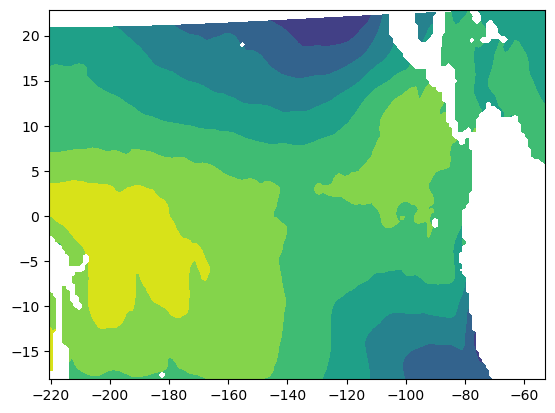

In [27]:
plt.contourf(tlon_pop_pac_lr, tlat_pop_pac_lr,
    ds_sst_low_cyc.SST.isel(time=100).sel(nlon=slice(0,150), nlat=slice(120,260)))

In [28]:
# %%time
# # get the mean for the tropical Pacific LOW RES
# pop_mean_pac_lr = ds_sst_low_cyc.SST.sel(nlon=slice(0,150), nlat=slice(120,260)).sel(time=slice('1998', '2021')).mean('time').load()
# # get the mean for the tropical Pacific
# pop_var_pac_lr = ds_sst_low_cyc.SST.sel(nlon=slice(0,150), nlat=slice(120,260)).sel(time=slice('1998', '2021')).var('time').load()

CPU times: user 3.28 s, sys: 387 ms, total: 3.67 s
Wall time: 3.83 s


In [29]:
# ds_pop_pac_lr = pop_var_pac_lr.to_dataset(name='var')
# ds_pop_pac_lr['mean'] = pop_mean_pac_lr
# ds_pop_pac_lr.to_zarr('pop_lr_pac_derived.zarr')

In [29]:
# %%time
# # get the means for the overlapping time period
# oisst_mean = (ds_oisst_tst.analysed_sst.sel(time=slice('1998', '2021'))-273.15).mean('time', skipna=True).load()
# # the pop one needs to be a subset because it is too much data otherwise
# # pop_mean_pac = ds_sst_high_cyc.SST.sel(nlat=slice(1000,1400), nlon=slice(1100,2300)).sel(time=slice('1998', '2021')).mean('time').load()

CPU times: user 35.3 s, sys: 2.74 s, total: 38 s
Wall time: 1min 5s


In [27]:
# %%time
# # get the variance for the overlapping time period
# oisst_var = (ds_oisst_tst.analysed_sst.sel(time=slice('1998', '2021'))-273.15).var('time', skipna=True).load()
# # pop_var_pac = ds_sst_high_cyc.SST.sel(nlat=slice(1000,1400), nlon=slice(1100,2300)).sel(time=slice('1998', '2021')).var('time').load()

CPU times: user 39.9 s, sys: 8.17 s, total: 48 s
Wall time: 2min 43s


In [33]:
tlon_pop_pac = dso_grid.TLONG.sel(nlat=slice(1000,1400), nlon=slice(1100,2300))
tlat_pop_pac = ds_grid.TLAT.sel(nlat=slice(1000,1400), nlon=slice(1100,2300))

CPU times: user 1.15 s, sys: 194 ms, total: 1.34 s
Wall time: 5.16 s


Text(0.5, 0, 'Longitude $^{\\circ}$E')

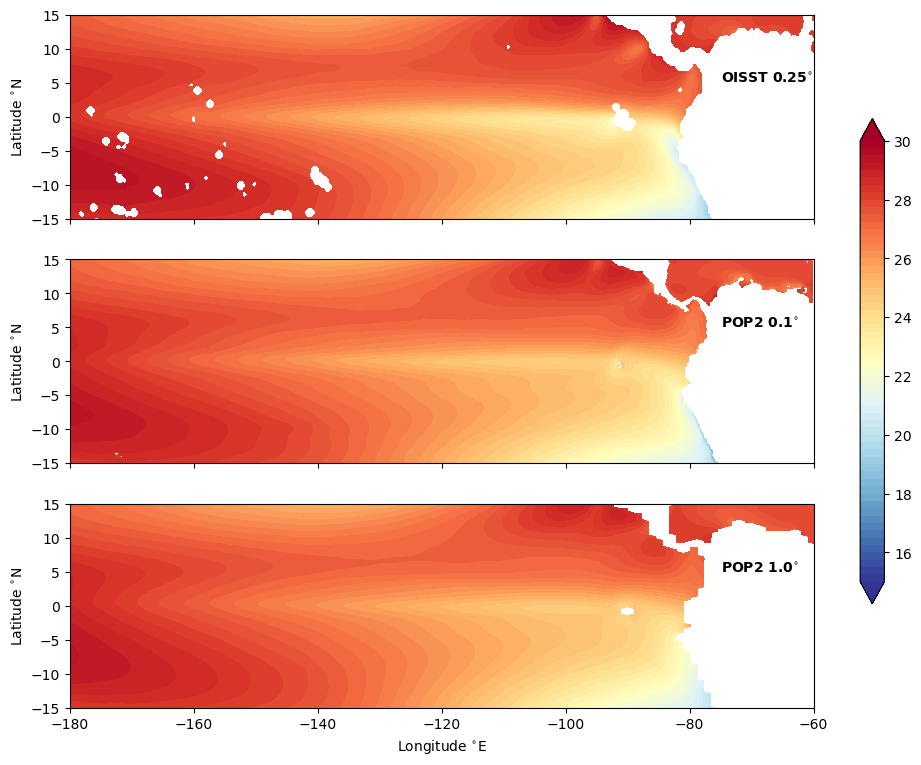

In [40]:
%%time
# get them to plot together ; you might have to move the longitude =/
fig, ax = plt.subplots(3, 1, figsize=(12,9), sharex=True, sharey=True)
dat = ax[0].contourf(ds_oisst_timvar.lon, ds_oisst_timvar.lat, ds_oisst_timvar['mean'], levels=np.arange(15,30.25,0.25), cmap='RdYlBu_r', extend='both')
# (ds_oisst_tst.analysed_sst.isel(time=100)-273.15).plot(levels=np.arange(15,32,1), cmap='RdYlBu_r', ax=ax[0])
ax[0].set_ylim(-15,15)

dat = ax[1].contourf(tlon_pop_pac, tlat_pop_pac, ds_pophr_timvar['mean'], levels=np.arange(15,30.25,0.25), cmap='RdYlBu_r', extend='both')
ax[1].set_ylim(-15,15)
ax[1].set_xlim(-180,-60)

dat = ax[2].contourf(tlon_pop_pac_lr, tlat_pop_pac_lr, ds_pop_pac_lr['mean'], levels=np.arange(15,30.25,0.25), cmap='RdYlBu_r', extend='both')
ax[2].set_ylim(-15,15)
ax[2].set_xlim(-180,-60)


plt.colorbar(dat, ax=ax[:], shrink=0.7, ticks=range(16,32,2))

ax[0].text(-75,5, r'OISST 0.25$^{\circ}$', c='k', weight='bold')
ax[1].text(-75,5, r'POP2 0.1$^{\circ}$', c='k', weight='bold')
ax[2].text(-75,5, r'POP2 1.0$^{\circ}$', c='k', weight='bold')

ax[0].set_ylabel(r'Latitude $^{\circ}$N')
ax[1].set_ylabel(r'Latitude $^{\circ}$N')
ax[2].set_ylabel(r'Latitude $^{\circ}$N')
ax[2].set_xlabel(r'Longitude $^{\circ}$E')

CPU times: user 944 ms, sys: 9.85 ms, total: 954 ms
Wall time: 1.5 s


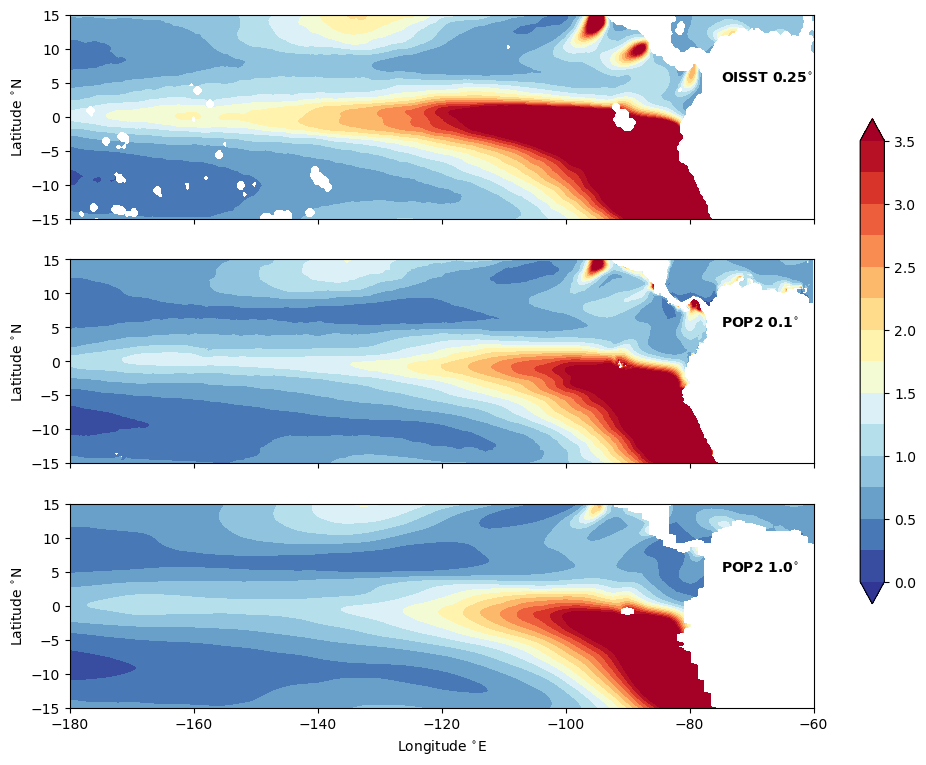

In [42]:
%%time
# get them to plot together ; you might have to move the longitude =/
fig, ax = plt.subplots(3, 1, figsize=(12,9), sharex=True, sharey=True)
dat = ax[0].contourf(ds_oisst_timvar.lon, ds_oisst_timvar.lat, ds_oisst_timvar['var'], levels=np.arange(0,3.75,0.25), cmap='RdYlBu_r', extend='both')
# (ds_oisst_tst.analysed_sst.isel(time=100)-273.15).plot(levels=np.arange(15,32,1), cmap='RdYlBu_r', ax=ax[0])
ax[0].set_ylim(-15,15)

dat = ax[1].contourf(tlon_pop_pac, tlat_pop_pac, ds_pophr_timvar['var'], levels=np.arange(0,3.75,0.25), cmap='RdYlBu_r', extend='both')
ax[1].set_ylim(-15,15)
ax[1].set_xlim(-180,-60)

dat = ax[2].contourf(tlon_pop_pac_lr, tlat_pop_pac_lr, ds_pop_pac_lr['var'], levels=np.arange(0,3.75,0.25), cmap='RdYlBu_r', extend='both')
ax[2].set_ylim(-15,15)
ax[2].set_xlim(-180,-60)

plt.colorbar(dat, ax=ax[:], shrink=0.7)

ax[0].text(-75,5, r'OISST 0.25$^{\circ}$', c='k', weight='bold')
ax[1].text(-75,5, r'POP2 0.1$^{\circ}$', c='k', weight='bold')
ax[2].text(-75,5, r'POP2 1.0$^{\circ}$', c='k', weight='bold')
ax[0].set_ylabel(r'Latitude $^{\circ}$N')
ax[1].set_ylabel(r'Latitude $^{\circ}$N')
ax[2].set_ylabel(r'Latitude $^{\circ}$N')
ax[2].set_xlabel(r'Longitude $^{\circ}$E')

plt.savefig('POP2_OISST_1998-2021_meanSST_Pacific_lrhr.png', bbox_inches='tight')